Total images loaded: 10000


Processing Images: 100%|██████████| 10000/10000 [00:38<00:00, 258.66it/s]


Total valid images after processing: 10000
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6216 - loss: 0.6871
Epoch 1: val_accuracy improved from -inf to 0.86500, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 176ms/step - accuracy: 0.6219 - loss: 0.6867 - val_accuracy: 0.8650 - val_loss: 0.3055 - learning_rate: 1.0000e-05
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8198 - loss: 0.4026
Epoch 2: val_accuracy improved from 0.86500 to 0.86700, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.8198 - loss: 0.4025 - val_accuracy: 0.8670 - val_loss: 0.2884 - learning_rate: 1.0000e-05
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8624 - loss: 0.3188
Epoch 3: val_accuracy improved from 0.86700 to 0.89850, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.8623 - loss: 0.3188 - val_accuracy: 0.8985 - val_loss: 0.2213 - learning_rate: 1.0000e-05
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━

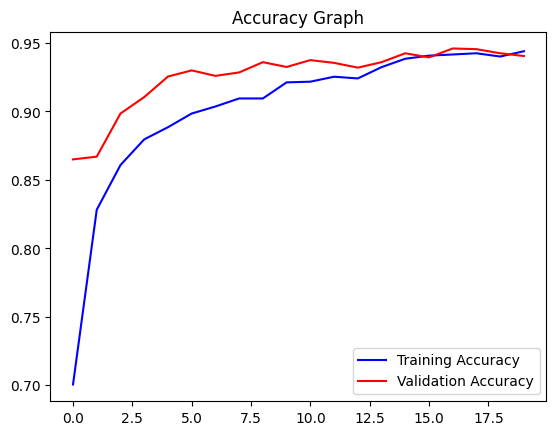

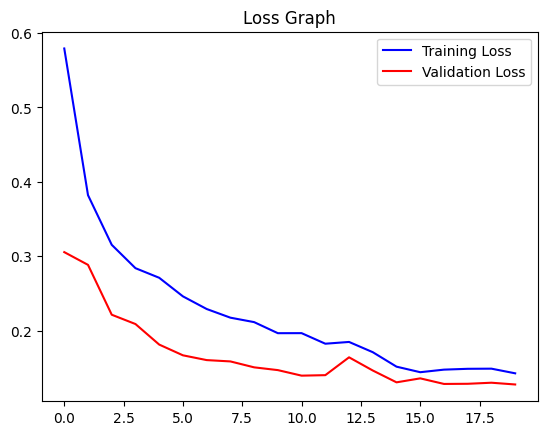

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


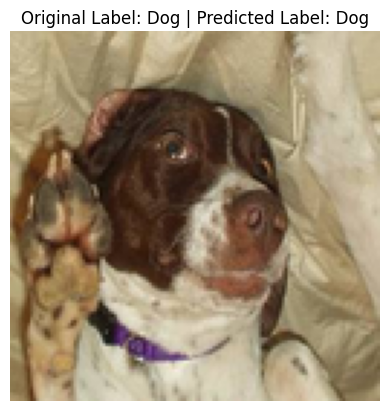

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Function Definitions
def read_images_and_labels_from_folder(folder_path, max_images=10000):
    """Read images and labels from the folder"""
    image_paths = []
    labels = []
    image_count = 0

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')) and image_count < max_images:
                file_path = os.path.join(root, file)
                label = 0 if 'cat' in file.lower() else 1
                image_paths.append(file_path)
                labels.append(label)
                image_count += 1
            if image_count >= max_images:
                break
        if image_count >= max_images:
            break

    return image_paths, labels

def extract_features(image_paths, labels):
    """Extract features from images and return consistent labels."""
    features = []
    valid_labels = []
    for path, label in tqdm(zip(image_paths, labels), desc="Processing Images", total=len(image_paths)):
        try:
            image = Image.open(path)
            image = image.resize((128, 128), Image.LANCZOS)
            img_array = np.array(image)
            if img_array.shape == (128, 128, 3):  # Ensure consistent shape
                features.append(img_array)
                valid_labels.append(label)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    features = np.array(features)
    features = features / 255.0  # Normalize
    return features, np.array(valid_labels)

def extract_zip(zip_file_path, extract_to_path):
    """Extract zip file"""
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)

# Main Execution
if __name__ == "__main__":
    zip_file = "/content/Pet Classification.zip"  # Replace with your zip file path
    extract_to_path = "dataset"

    # Extract dataset
    os.makedirs(extract_to_path, exist_ok=True)
    extract_zip(zip_file, extract_to_path)

    # Reading images and labels
    image_paths, labels = read_images_and_labels_from_folder(extract_to_path, max_images=10000)
    print(f"Total images loaded: {len(image_paths)}")

    # Extracting features
    X, y = extract_features(image_paths, labels)
    print(f"Total valid images after processing: {len(X)}")

    # Split dataset
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Class weights
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    # Data Augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

    # Model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    base_model.trainable = True
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    inputs = Input((128, 128, 3))
    x = base_model(inputs, training=True)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    checkpoint_path = 'best_model.keras'
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )

    # Training
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=val_generator,
        class_weight=class_weights,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    # Plot Accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Accuracy Graph')
    plt.legend()
    plt.show()

    # Plot Loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()

    # Test Prediction
    label_dict = {0: 'Cat', 1: 'Dog'}
    image_index = 0  # Replace with desired index
    pred = model.predict(X[image_index].reshape(1, 128, 128, 3))
    pred_label = label_dict[round(pred[0][0])]

    plt.imshow(X[image_index])
    plt.title(f"Original Label: {label_dict[y[image_index]]} | Predicted Label: {pred_label}")
    plt.axis('off')
    plt.show()